# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Reviewer's comment </h2>
    
Good introduction! 

</div>

## Preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import arma_order_select_ic
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Load data
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Sort index
taxi.sort_index(inplace=True)

# Resample by one hour
taxi_hourly = taxi.resample('1H').sum()

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Reviewer's comment </h2>
    
Good! 
</div>

</div>

## Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


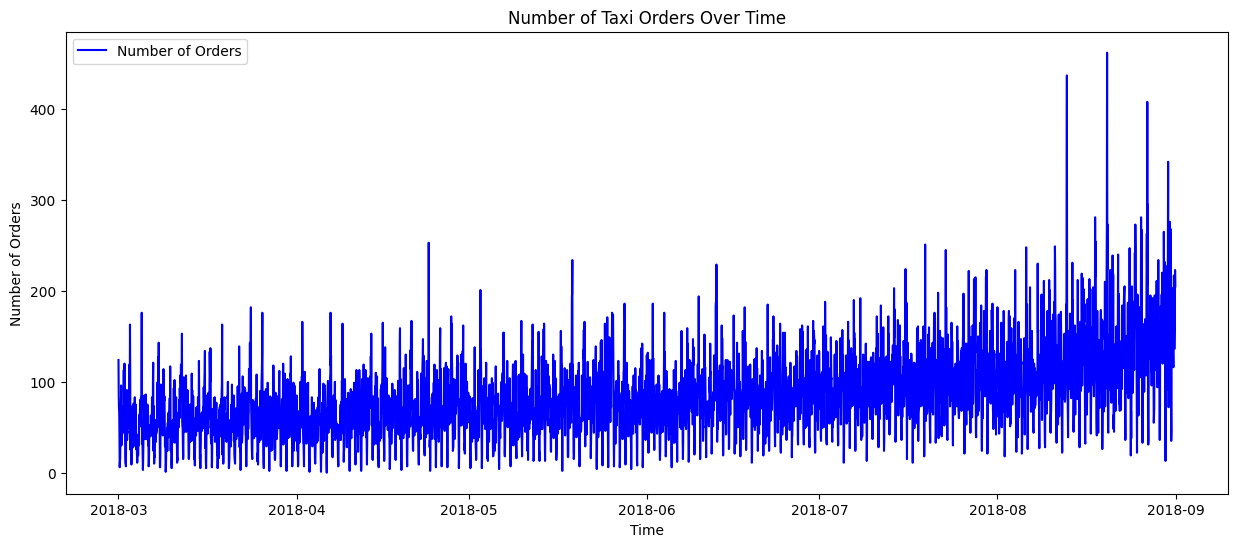

In [3]:
print(taxi_hourly.info())

# Plot a line plot of the number of orders over time
plt.figure(figsize=(15, 6))
plt.plot(taxi_hourly.index, taxi_hourly['num_orders'], label='Number of Orders', color='blue')
plt.title('Number of Taxi Orders Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

</div>
<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Reviewer's comment 2 </h2>
    
Looks really nice!     
</div>

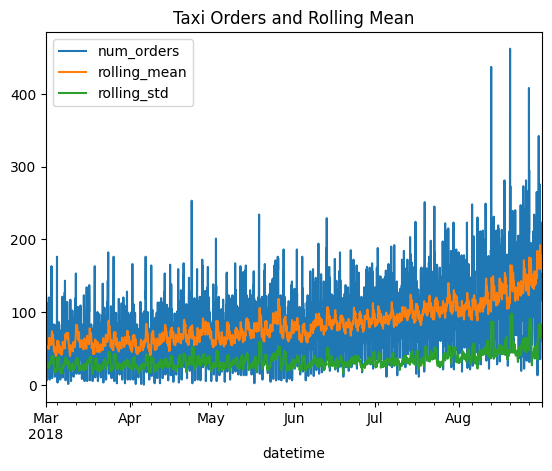

In [4]:
# Calculate the rolling mean with a window size of 20
taxi_hourly['rolling_mean'] = taxi_hourly['num_orders'].shift().rolling(window=20).mean()
taxi_hourly['rolling_std'] = taxi_hourly['num_orders'].shift().rolling(window=20).std()

# Plot the data
taxi_hourly.plot()
plt.title('Taxi Orders and Rolling Mean')
plt.show()

# Print the number of missing values in each column
taxi_hourly = taxi_hourly.drop(columns=['rolling_mean', 'rolling_std'])

<AxesSubplot:xlabel='datetime'>

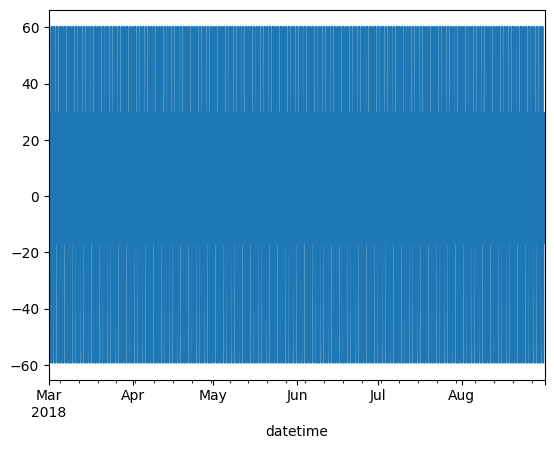

In [5]:
decomposed = seasonal_decompose(taxi_hourly['num_orders'])

decomposed.seasonal.plot()

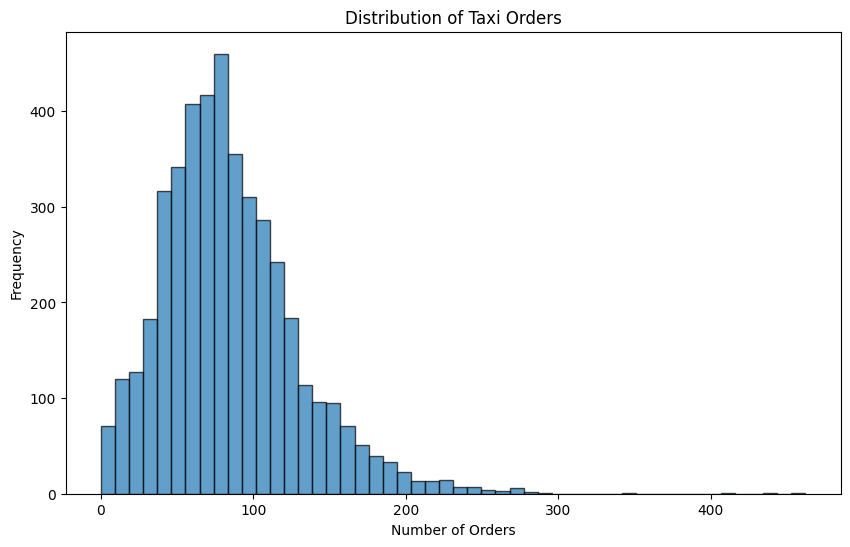

In [6]:
# Plot a histogram of the number of orders

plt.figure(figsize=(10, 6))
plt.hist(taxi_hourly['num_orders'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Taxi Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()

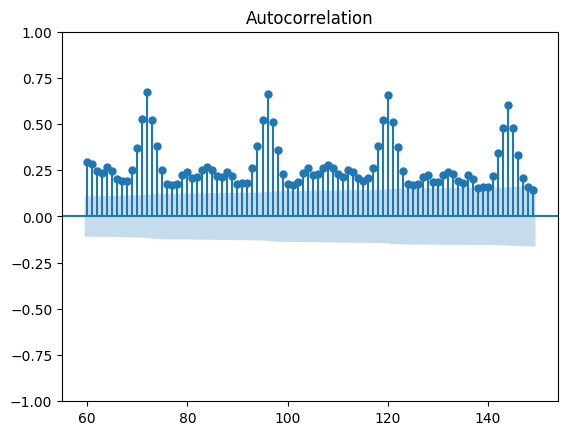

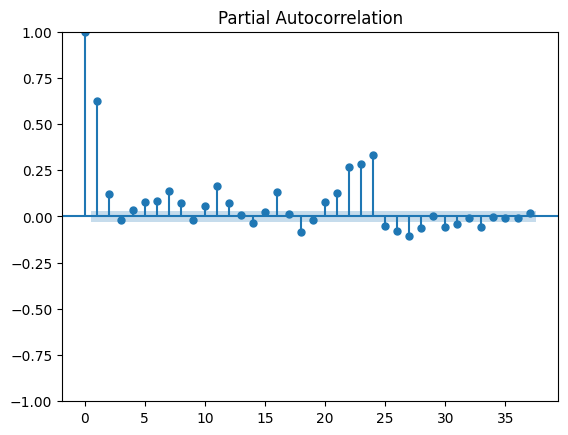

In [7]:
plot_acf(taxi_hourly['num_orders'], lags=range(60, 150))
plot_pacf(taxi_hourly['num_orders'])
plt.show()

In [8]:
# Perform differencing
diff_series = taxi_hourly['num_orders'].diff().dropna()

# ADF test
result = adfuller(diff_series)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -15.793234257410496
p-value: 1.095877674651026e-28


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid black;">
<h2>Reviewer's Comment</h2>
`seasonal_decompose` is a great method, well done!
</div>

# Analysis Conclusions
From the ADF test, I determined the data is stationary.
Additionally, the most frequent number of taxi orders in a single hour is approximately 90 orders.


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Reviewer's comment 2 </h2>
    
Great!     
</div>

## Training

In [9]:
# Data preparation
def make_features(data, max_lag, rolling_mean_size):
    # Creating time-based features
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    # Creating lag features
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    # Creating rolling mean feature
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
        
    return data

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Reviewer's Comment </h2>
    
Correct. Sometimes we can notice autocorrelation in time series. It means that the current value of the series depends on the previous values. Including so-called lag components allows machine learning models, such as linear regression, to take this dependency into account.
</div>


Fixed

In [10]:
# Make features
taxi_hourly = make_features(taxi_hourly, 4, 20)

# Split into train and test sets
train, test = train_test_split(taxi_hourly, shuffle=False, test_size=0.1)
train = train.dropna()

# Make features and target
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [11]:
# find optimal number of lags

mod = ar_select_order(endog=train['num_orders'], maxlag=30)
ar_order = mod.ar_lags
print("Lags that define the AR model order:", ar_order)

Lags that define the AR model order: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [12]:
'''
# Define batch size
batch_size = 200

# Split data into batches
batches = [train['num_orders'][i:i+batch_size] for i in range(0, len(train), batch_size)]

# Find optimal model with batch processing, because it wouldn't otherwise
for i, batch in enumerate(batches):
    # Fit auto_arima model
    model = auto_arima(batch, seasonal=True, m=24)

    # Print summary of the best model for each batch
    print(f"Summary of Batch {i+1}:")
    print(model.summary())
'''

'\n# Define batch size\nbatch_size = 200\n\n# Split data into batches\nbatches = [train[\'num_orders\'][i:i+batch_size] for i in range(0, len(train), batch_size)]\n\n# Find optimal model with batch processing, because it wouldn\'t otherwise\nfor i, batch in enumerate(batches):\n    # Fit auto_arima model\n    model = auto_arima(batch, seasonal=True, m=24)\n\n    # Print summary of the best model for each batch\n    print(f"Summary of Batch {i+1}:")\n    print(model.summary())\n'

^ This came out with a bunch of different parameters obviously, but I had no what parameters or what model to use, so I tested out a few of the ones it gave and went with the model it recommended.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Reviewer's comment </h2>
    
Correct. Working with time series, we should not shuffle the data. 

</div>


In [13]:
# Example with LinearRegression model

linReg = LinearRegression()

linReg.fit(features_train, target_train)

lin_pred_test = linReg.predict(features_test)

rmse_lr = np.sqrt(mean_squared_error(target_test, lin_pred_test))

print(rmse_lr)

56.00061055366246


In [14]:
# Example with Random Forest model

# Initialize
forest = RandomForestRegressor(random_state=12345)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': list(range(50, 120)),  # Previously used list(range(70, 110)) and [90] to test the max_depth
    'max_depth': [None] # Previously used list(range(1, 40)) and got 59.17885179612059 with n_estimators = 99
}

# Initialize GridSearchCV with RMSE as the scoring metric
grid_search_f = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', # Use negative RMSE (since greater is better for GridSearchCV)
    cv=TimeSeriesSplit(n_splits=3),  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPUs
    verbose=2
)

# Fit the grid search to the data
grid_search_f.fit(features_train, target_train)

# Get the best estimator and its parameters
best_rf = grid_search_f.best_estimator_
print("Best parameters found: ", grid_search_f.best_params_)

# Predict on the test set
forest_pred = best_rf.predict(features_test)

# Calculate RMSE on the test set
forest_rmse = np.sqrt(mean_squared_error(target_test, forest_pred))
print("RMSE: ", forest_rmse)


Fitting 3 folds for each of 70 candidates, totalling 210 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.4s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.6s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.9s
[CV] END ....................max_depth=None, n_estimators=51; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=51; total time=   0.6s
[CV] END ....................max_depth=None, n_estimators=51; total time=   0.9s
[CV] END ....................max_depth=None, n_estimators=52; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=52; total time=   0.6s
[CV] END ....................max_depth=None, n_estimators=52; total time=   0.9s
[CV] END ....................max_depth=None, n_estimators=53; total time=   0.3s
[CV] END ....................max_depth=None, n_estimators=53; total time=   0.6s
[CV] END ....................max_depth=None, n_

[CV] END ....................max_depth=None, n_estimators=83; total time=   1.4s
[CV] END ....................max_depth=None, n_estimators=84; total time=   0.5s
[CV] END ....................max_depth=None, n_estimators=84; total time=   0.9s
[CV] END ....................max_depth=None, n_estimators=84; total time=   1.4s
[CV] END ....................max_depth=None, n_estimators=85; total time=   0.5s
[CV] END ....................max_depth=None, n_estimators=85; total time=   0.9s
[CV] END ....................max_depth=None, n_estimators=85; total time=   1.4s
[CV] END ....................max_depth=None, n_estimators=86; total time=   0.5s
[CV] END ....................max_depth=None, n_estimators=86; total time=   0.9s
[CV] END ....................max_depth=None, n_estimators=86; total time=   1.4s
[CV] END ....................max_depth=None, n_estimators=87; total time=   0.5s
[CV] END ....................max_depth=None, n_estimators=87; total time=   1.0s
[CV] END ...................

[CV] END ...................max_depth=None, n_estimators=117; total time=   1.9s
[CV] END ...................max_depth=None, n_estimators=118; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=118; total time=   1.3s
[CV] END ...................max_depth=None, n_estimators=118; total time=   2.0s
[CV] END ...................max_depth=None, n_estimators=119; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=119; total time=   1.3s
[CV] END ...................max_depth=None, n_estimators=119; total time=   2.0s
Best parameters found:  {'max_depth': None, 'n_estimators': 65}
RMSE:  58.47391653633378


Best parameters found:  {'max_depth': None, 'n_estimators': 65}
RMSE:  58.47391653633378

(Changed from 64 to 65 after adding TimeSeriesSplit)

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Reviewer's comment 3</h2>
    
Good!
</div>

In [15]:
# Example with SARIMAX model

sarimax = SARIMAX(train['num_orders'], order=(1, 1, 0), seasonal_order=(2, 0, 1, 24), random_state=12345)

sarimax = sarimax.fit(disp=False)

sarimax_pred = sarimax.predict(start=len(features_train), end=len(features_train) + len(features_test) - 1)

sarimax_rmse = np.sqrt(mean_squared_error(target_test, sarimax_pred))

print(sarimax_rmse)

40.14134123018374


## Testing

LinearRegression - 56.00061055366246

RandomForestRegressor - 58.47391653633378

SARIMA - 40.14134123018374

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Reviewer's comment </h2>
    
Nice results! 
</div>


# Conclusion:

Based on the tests conducted, SARIMAX demonstrates superior performance compared to the other three models tested. It is recommended as a suitable choice for predicting the next hour for Sweet Lift Taxi.

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48